## Exploratory Data Analysis

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [191]:
concrete = pd.read_csv('data/concrete.csv')
co2 = pd.read_csv('data/co2.csv')

concrete['co2_lower'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'lower_bound'].values[0] for col in concrete.columns[:7]])
concrete['co2_upper'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'upper_bound'].values[0] for col in concrete.columns[:7]])
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
 9   co2_lower     1030 non-null   float64
 10  co2_upper     1030 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 88.6 KB


In [192]:
concrete_train, concrete_test = train_test_split(concrete,
                                                 shuffle=True,
                                                 random_state=48)

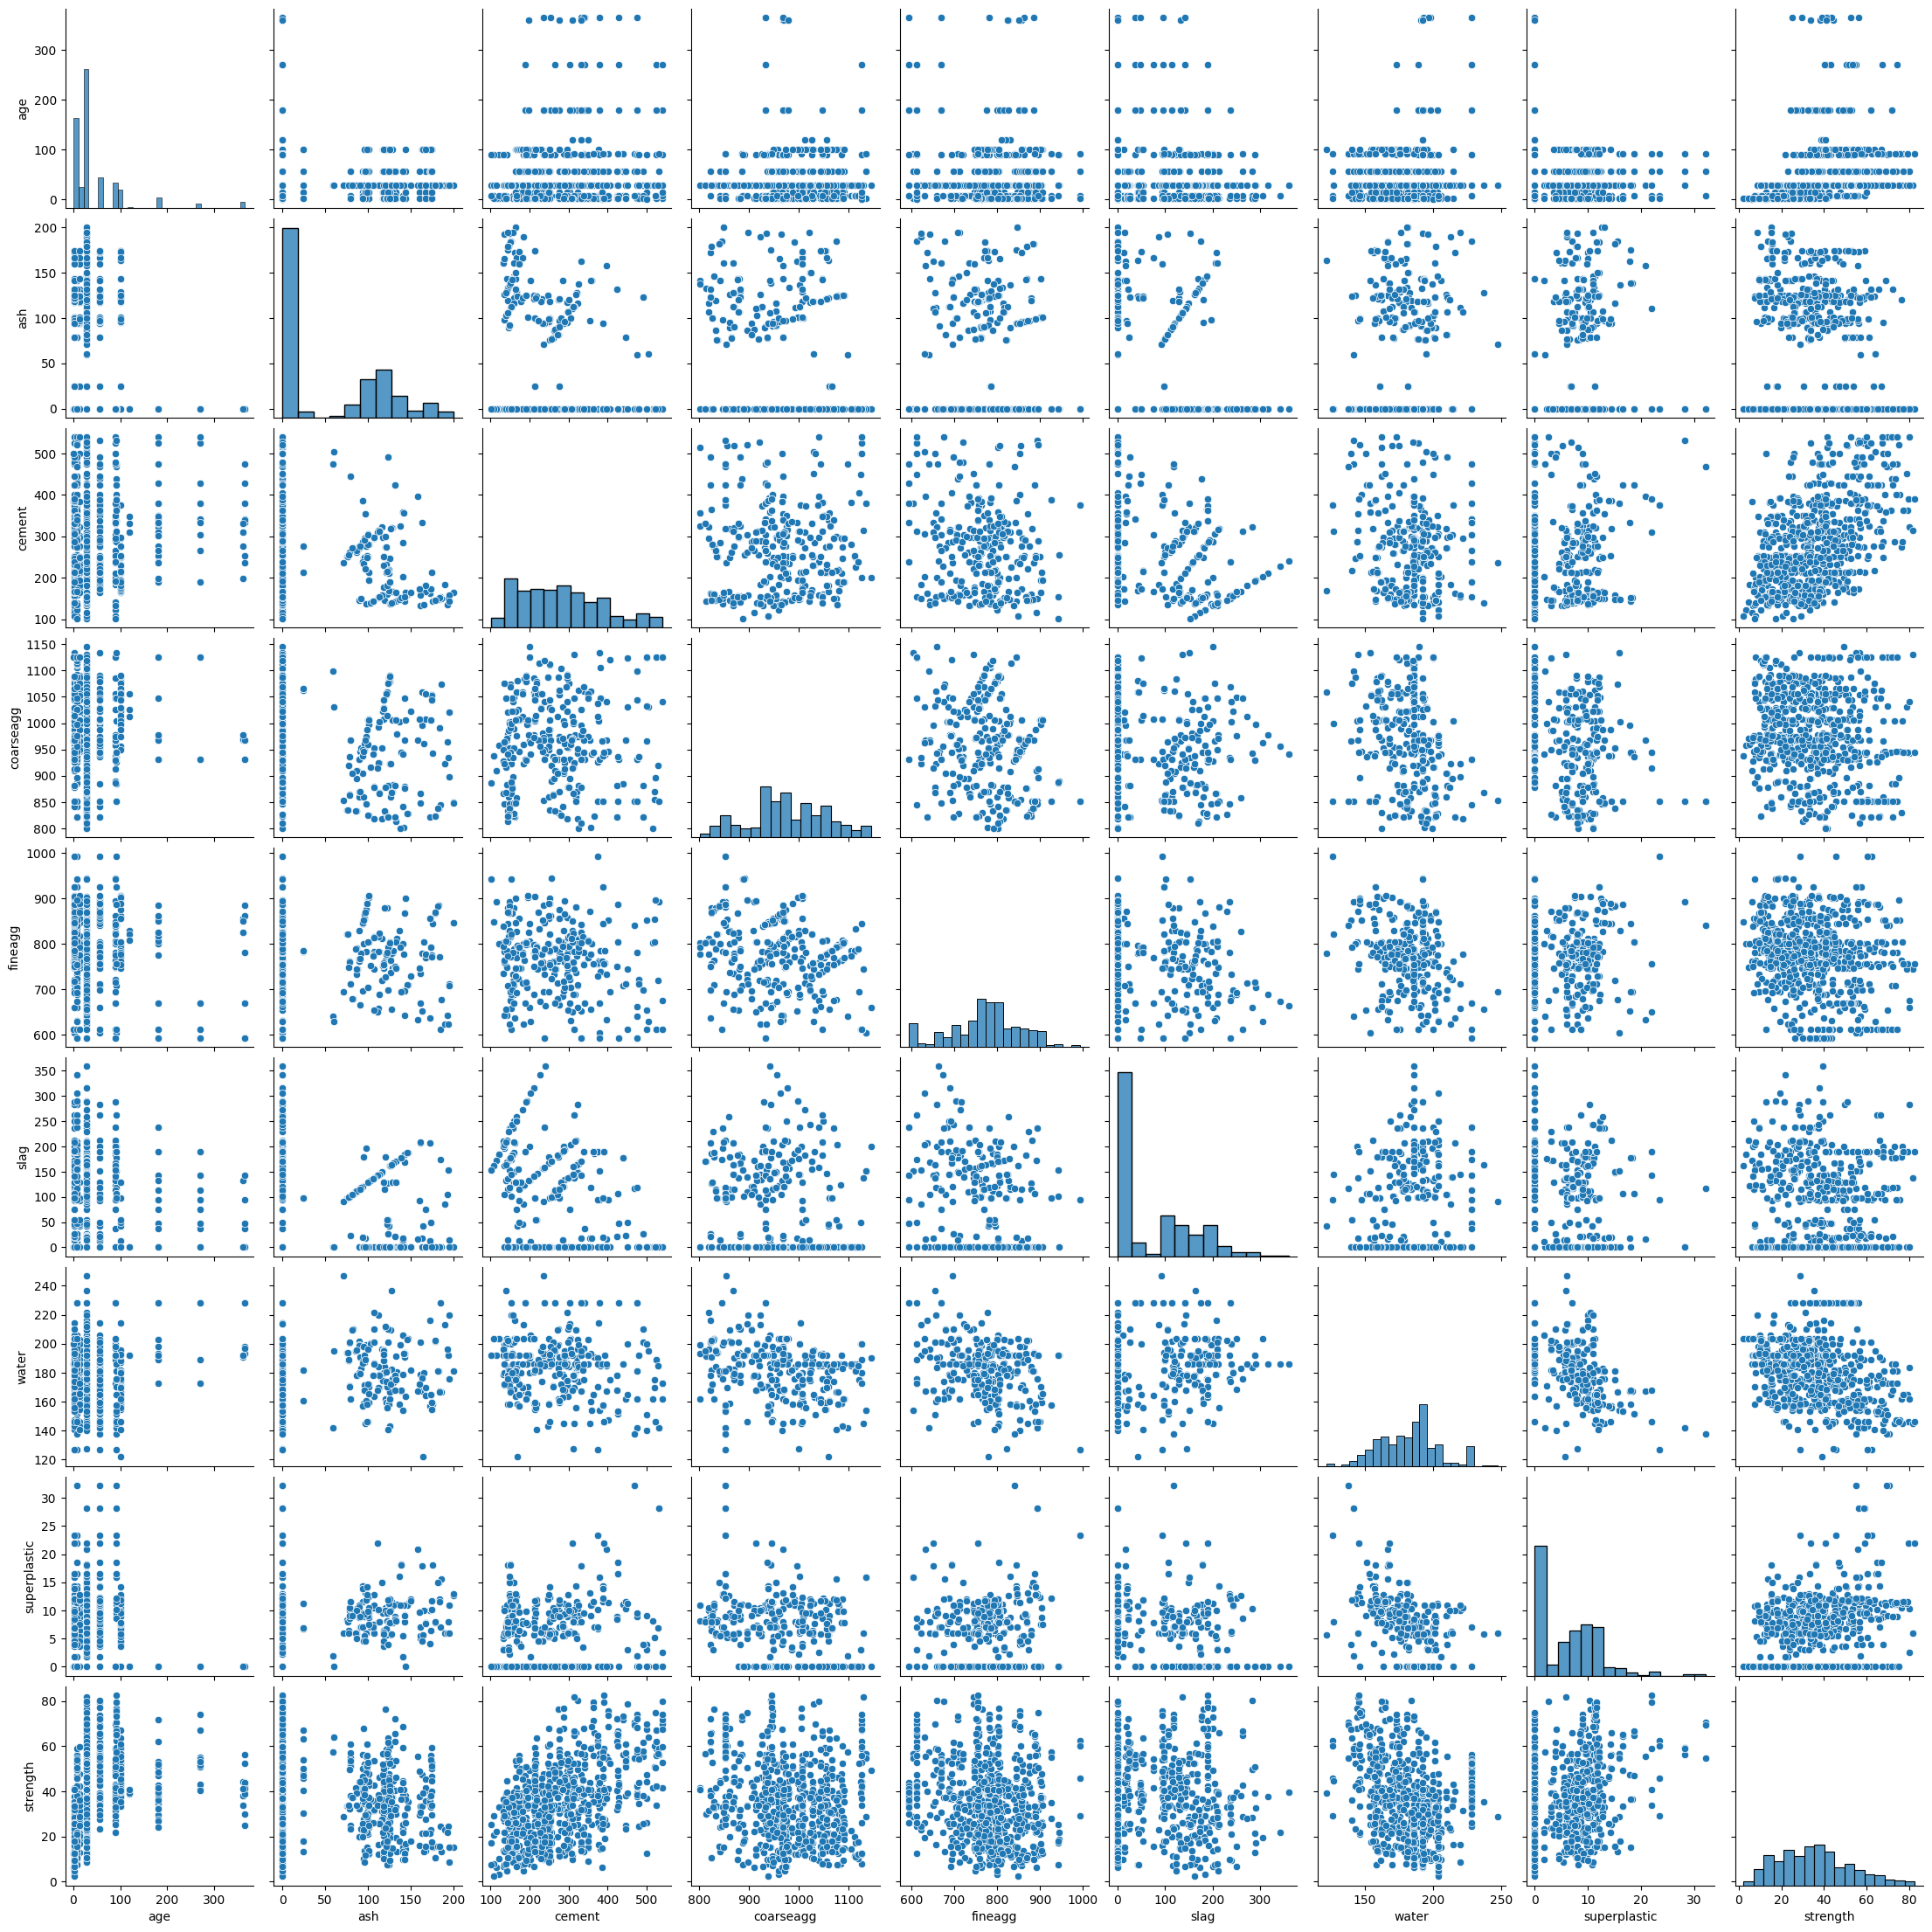

In [193]:
sns.pairplot(concrete_train[['age','ash','cement','coarseagg','fineagg','slag','water','superplastic','strength']])
plt.show()

It looks like the data with age greater than 120 days is both small and not representative of the the data as a whole, so we will remove it from our dataframe.

Also, there is an even split between data featuring each combination of ash, slag > 0 or = 0. So we will split this data and perhaps allow the user to pick his preference.

In [194]:
concrete = concrete[concrete['age'] < 120]

In [195]:
concrete_as = concrete[(concrete['ash'] > 0) & (concrete['slag'] > 0)]
concrete_a = concrete[(concrete['ash'] > 0) & (concrete['slag'] == 0)]
concrete_s = concrete[(concrete['ash'] == 0) & (concrete['slag'] > 0)]
concrete_ = concrete[(concrete['ash'] == 0) & (concrete['slag'] == 0)]

In [196]:
concrete_train, concrete_test = train_test_split(concrete,
                                                 shuffle=True,
                                                 random_state=487)

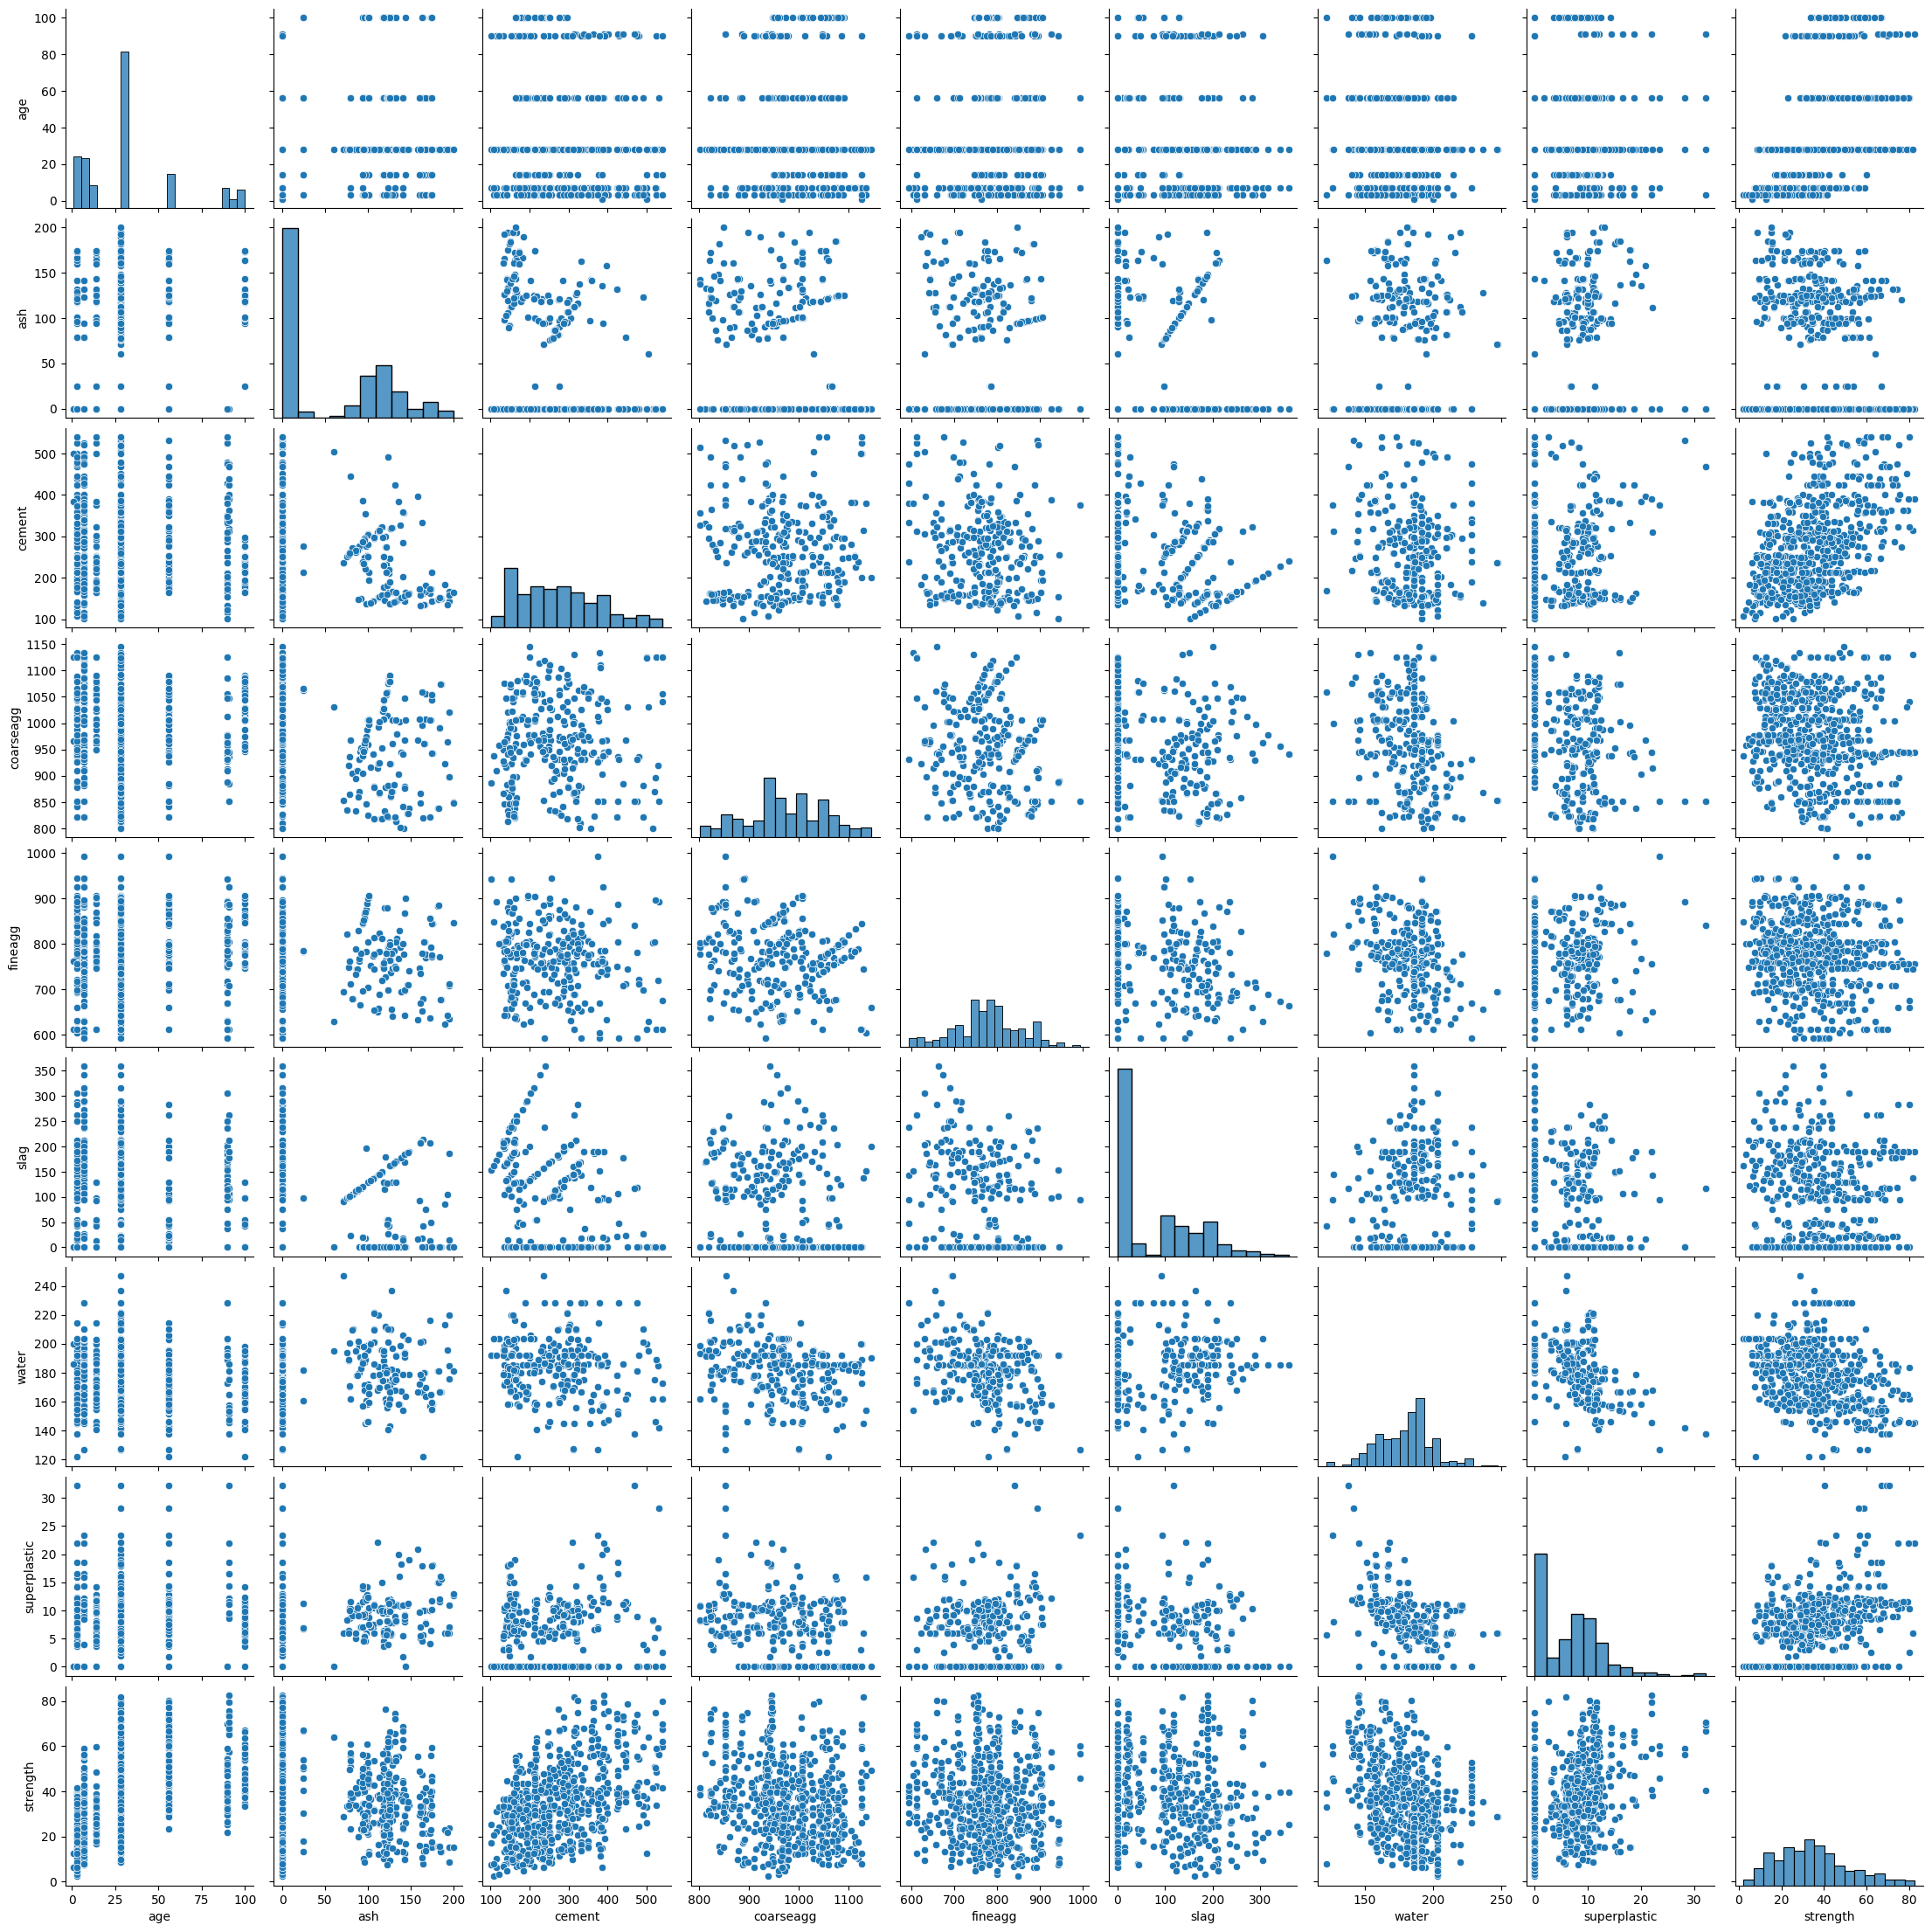

In [197]:
sns.pairplot(concrete_train[['age','ash','cement','coarseagg','fineagg','slag','water','superplastic','strength']])
plt.show()

This looks better.

### Exponential model for age

We know from the literature that the strength of concrete is roughly M - Ce^(-kt), so we try to find the best fit

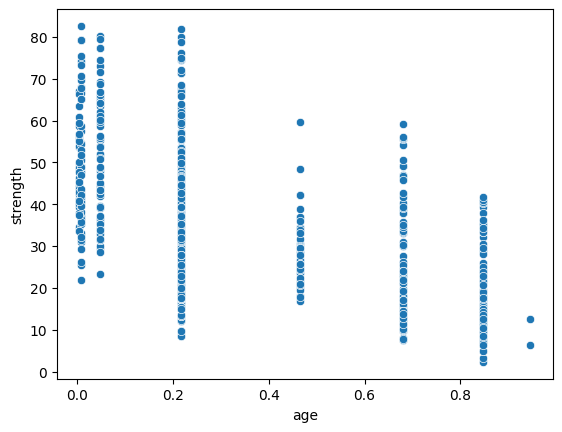

In [198]:
sns.scatterplot(data=concrete_train,
                x=np.exp(-20 * concrete_train['age']/365),
                y='strength')

plt.show()

In [199]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [200]:
# for future use, this function gets mean squared error without constantly copy-pasting

def get_slr_mses(data, features_list, y, n_splits=5, rs=97):
    # data is the dataframe
    # features_list is a list of all lists of features we wish to compare
    # eg [[], ['feature1'], ['feature1', 'feature2, 'feature5']]
    # if one list is [], then we make a baseline prediction
    # y is the y feature we are predicting
    # k is the number of cross-validation splits
    # rs is the random_state for kfold
    kfold = KFold(n_splits,
              shuffle=True,
              random_state=rs)
    mses=np.zeros((n_splits, len(features_list)))

    i = 0
    # cross-validation
    for train_index, test_index in kfold.split(data):
        data_tt = data.iloc[train_index]
        data_ho = data.iloc[test_index]

        j = 0
        for features in features_list:
            if features == []:
                # baseline prediction
                pred = data_tt[y].values.mean() * np.ones(len(data_ho))
            else:
                reg = LinearRegression(copy_X=True)
                reg.fit(data_tt[features], data_tt[y])
                pred = reg.predict(data_ho[features])
            
            mses[i, j] = mean_squared_error(y_true=data_ho[y],
                                            y_pred=pred)
            j += 1
        
        i += 1

    return np.mean(mses, axis=0)



In [201]:
for factor in np.arange(.01, .1, .01):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    print(factor, get_slr_mses(concrete_train, [['exp_age']], 'strength')[0])

0.01 200.2406320671938
0.02 194.63842040407684
0.03 193.28344760374944
0.04 194.8972417001004
0.05 198.00904675170085
0.060000000000000005 201.58213791777345
0.06999999999999999 205.05884045548297
0.08 208.20291145712144
0.09 210.9513484020618


In [202]:
exp_age_mses = []
for factor in np.arange(.02, .04, .001):
    concrete_train['exp_age'] = np.exp(-factor * concrete_train['age'])
    exp_age_mses.append(get_slr_mses(concrete_train, [['exp_age']], 'strength')[0])

print(np.arange(.025, .55, .001)[np.argmin(exp_age_mses)], np.min(exp_age_mses))

0.03400000000000001 193.2593609700949


In [203]:
concrete_train['exp_age'] = np.exp(-.034 * concrete_train['age'])

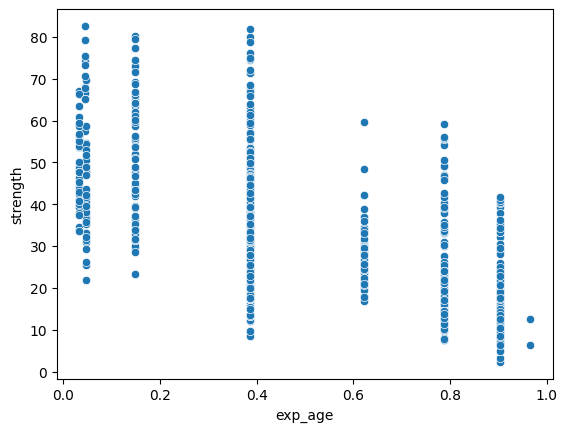

In [204]:
sns.scatterplot(data=concrete_train,
                x='exp_age',
                y='strength')

plt.show()

In [205]:
# This function was modified from stackexchange user hughdbrown 
# at this link, 
# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset

# This returns the power set of a set minus the empty set
def powerset(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
        
    return power_set[1:]

In [206]:
all_features = [[]] + powerset(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'exp_age'])

In [207]:
all_mses = get_slr_mses(concrete_train, all_features, 'strength')

In [208]:
print(all_features[np.argmin(all_mses)], np.min(all_mses))

['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg', 'fineagg', 'exp_age'] 47.26390430478159
